In [1]:
import logging 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
import numpy as np
import pandas as pd
import h5py
from keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.2.0-dev20200430
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Определим генераторы для тренировочного и валидационного набора данных

Для того, чтобы генераторы работали корректно, необходимо соблюсти ниже приведенную структуру папок, хранящих изображения для обучения и тестирования.

![](structure.jpeg "Title")

Объекты класса ImageDataGenerator позволяют определить в себе методы для аугментации данных. Определим методы аугментации для тренировочного набора данных, а набор данных для валидации расширять не будем.

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=10,
        zoom_range=0.10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        vertical_flip = True,
)

valid_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
)

Создадим необходимые для обучения генераторы, в которых определим размер поступающих на вход изображений, их количество в 
партии и количество классов для классификации. 


In [4]:
train_generator = train_datagen.flow_from_directory(
    directory='Data/grid_screenshots/Train',
    target_size=(350, 250),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 831 images belonging to 2 classes.


In [5]:
valid_generator = valid_datagen.flow_from_directory(
    directory='Data/grid_screenshots/Valid',
    target_size=(350, 250),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
)

Found 124 images belonging to 2 classes.


## Создадим модель и определим метрики качества

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters = 16, kernel_size = (11, 11),padding = 'Same',
                 activation ='relu', input_shape=(350, 250, 3)),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 32, kernel_size = (7, 7), padding = 'Same',
                 activation ='relu',),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same',
                 activation ='relu',),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same',
                 activation ='relu',),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Conv2D(filters = 128, kernel_size = (2, 2), padding = 'Same',
                 activation ='relu',),
  tf.keras.layers.MaxPooling2D(pool_size = 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

В качестве метрик будем использовать матрицу ошибок.

![123](matrix.png "Title")

У бинарного классификатора есть 4 возможных исхода предсказания.\
TruePositive - на выходе классификатора '1' и объект действительно принадлежит классу '1'. Это "правильное обнаружение".\
FalsePositive - на выходе классификатора '1', а объект принадлежит классу '0'. Это "ложная тревога".\
FalseNegative - на выходе классификатора '0', а объект принадлежит классу '1'. Это "пропуск цели".\
TrueNegative - на выхоже классификатора '0', и объект действительно принадлежит классу '0'. Это "правильное необнаружение".

Из этого вытекают следующие метрики:\
Accuracy - точность предсказания. Показывает долю правильных ответов из всех ответов классификатора.\
$$
Accuracy = {TP+TN \over TP+TN+FP+FN}
$$
Precision - доля правильных ответов, когда на выходе классификатора '1'\
$$
Precision = {TP \over TP+FP}
$$
Recall - доля правильных ответов, когда на вход классификатору подают только класс '1'
$$
Recall = {TP \over TP+FN}
$$

AUC - площадь под ROC-кривой. Даёт количественную интерпретацию ROC-кривой. Выражаясь простыми словами, значение auc = 0.5 
говорит о том, что классификатор не обучен и выдает совершенно случайные ответы. Чем ближе auc к единице, тем лучше обучен классификатор. 

In [7]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(
      optimizer=keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

## Запустим процесс обучения

Воспользуемся чекпоинтами - способом сохранять модели по определеным правилам во время обучения. 
Сделаем так, чтобы во время обучения сохранялись те модели, точность которых превысила значения на прошлых эпохах и затем запустим обучение.

In [8]:
weights = {0:1, 1:1.05} #Для повышения метрики Recall, дадим классу '1' вес, выше чем классу '0'. 

#reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=200, min_lr=0.001)
#earlyStopping = EarlyStopping(monitor='val_accuracy', patience=200, verbose=0, mode='auto')
mcp_save = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{recall:03f}-{val_accuracy:03f}-{val_recall:03f}.h5',
                           verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

EPOCHS = 250

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//valid_generator.batch_size,
    verbose = 1,
    class_weight=weights, 
    callbacks=[mcp_save]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
25/25 [==============================] - ETA: 0s - loss: 0.7096 - tp: 88.0000 - fp: 88.0000 - tn: 338.0000 - fn: 286.0000 - accuracy: 0.5325 - precision: 0.5000 - recall: 0.2353 - auc: 0.5244
Epoch 00001: val_accuracy improved from -inf to 0.09375, saving model to model-001-0.532500-0.235294-0.093750-1.000000.h5
25/25 [==============================] - 21s 849ms/step - loss: 0.7096 - tp: 88.0000 - fp: 88.0000 - tn: 338.0000 - fn: 286.0000 - accuracy: 0.5325 - precision: 0.5000 - recall: 0.2353 - auc: 0.5244 - val_loss: 0.7115 - val_tp: 9.0000 - val_fp: 87.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0938 - val_precision: 0.0938 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/250
25/25 [==============================] - ETA: 0s - loss: 0.7094 - tp: 73.0000 - fp: 93.0000 - tn: 338.0000 - fn: 295.0000 - accuracy: 0.5144 - precision: 0.4398 - recall: 0.1984 - auc: 0.5020
Epoch 00002: 

In [9]:
model.save('model_1.h5')

## Посмотрим на результат обучения

Выберем одну картинку, подадим на вход классификатора и посмотрим на его выход. Классификатор угадал, на картинке со школой 
выход нейронной сети - '1'.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/home/lendumat/.local/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


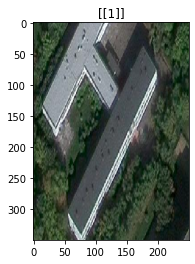

In [10]:
image_path="Data/grid_screenshots/Valid/School/school_50.png"
img = image.load_img(image_path, target_size=(350, 250))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result = model.predict_classes(img)
plt.title(result)
plt.show()

## Построим графики обучения

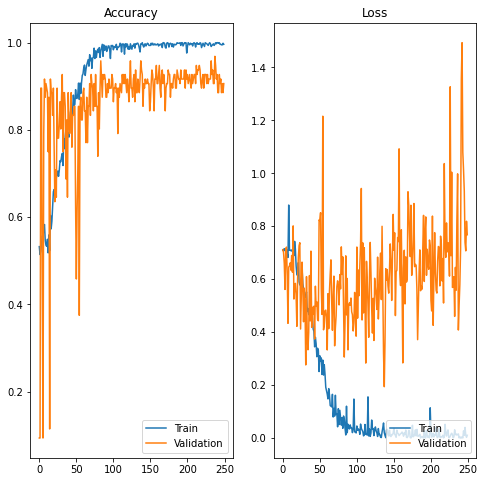

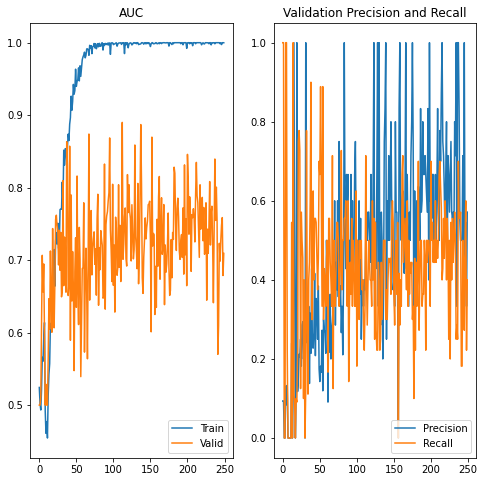

In [12]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

epochs_range = range(250)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='lower right')
plt.title('Loss')

plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Train')
plt.plot(epochs_range, val_auc, label='Valid')
plt.legend(loc='lower right')
plt.title('AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_precision, label='Precision')
plt.plot(epochs_range, val_recall, label='Recall')
plt.legend(loc='lower right')
plt.title('Validation Precision and Recall')

plt.show()

Судя по графикам, обучение прошло удовлетворительно. График точности для тренировочного и валидационногого набора данных постоянно увеличивался и стремился к единице. График функции потерь для тренировочного датасета всегда уменьшался, в то время как на валидационном датасете он имеет непостоянную структуру. Это может говорить либо о переобучении модели, либо о некорректно собранном наборе данных. Но в тоже время график AUC показывает, что модель обучилась удовлетворительно, потому что значение AUC превышает 0.5 и для тренировочного и валидационного набора данных.